>>> [Step 1] Data Loading & Splitting...
Split Index (Time 34): 29894
Train Set: (29894, 165), Test Set: (16670, 165)

>>> [Step 2] Training Baseline Random Forest...
✅ Baseline RF F1 (Th=0.5): 0.8126

>>> [Step 3] Optimization 1: Threshold Moving...
🚀 Best Threshold Found: 0.4200
🚀 Optimized F1-Score:   0.8220 (Improvement: +0.0094)


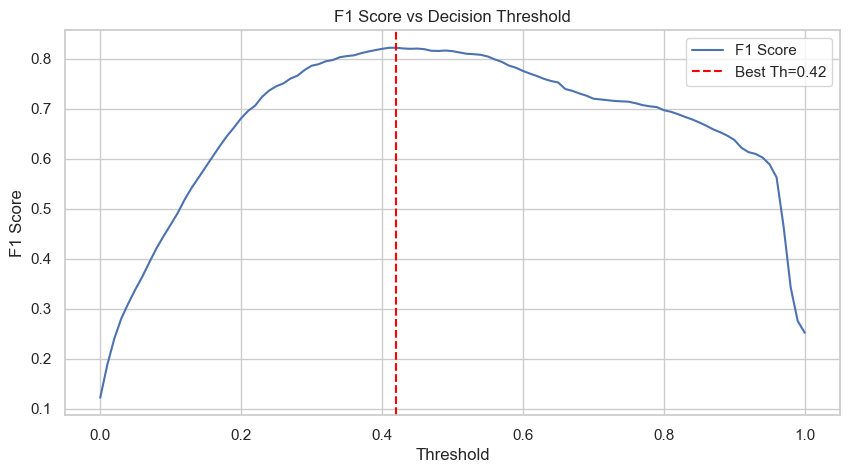


>>> [Step 4] Optimization 2: Feature Analysis...
Top 10 Features:
   1. Feat_54 (0.0581)
   2. Feat_46 (0.0525)
   3. Feat_48 (0.0430)
   4. Feat_40 (0.0403)
   5. Feat_52 (0.0361)
   6. Feat_89 (0.0354)
   7. Feat_42 (0.0342)
   8. Feat_22 (0.0257)
   9. Feat_28 (0.0252)
   10. Feat_17 (0.0249)


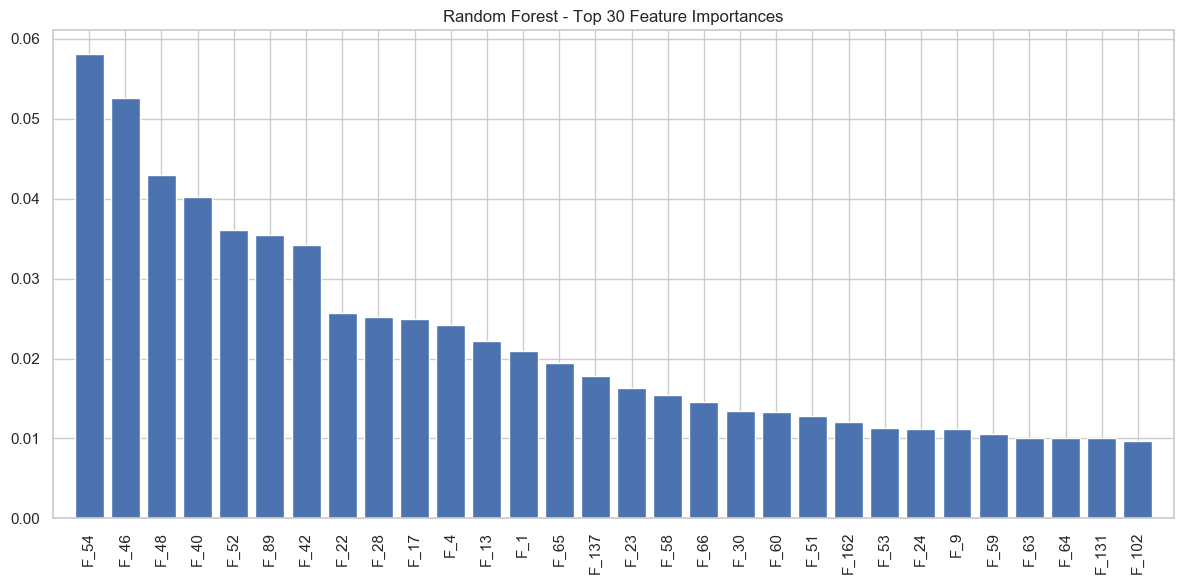

Re-training with Top 80 Features...
✅ Top-80 Features F1 (Optimized): 0.8218
Feature Selection did not improve. Using all features is better.

>>> [Step 5] Optimization 3: Hyperparameter Tuning (RandomizedSearch)...
   (This might take 1-2 minutes...)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

🏆 Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced_subsample'}
🏆 Best CV F1 Score: 0.4477

🚀 Final Optimized RF F1 Score: 0.8267 (at Th=0.52)

>>> Final Optimization Summary
Method                         | F1-Score  
---------------------------------------------
1. Baseline (Th=0.5)           | 0.8126
2. Threshold Moving            | 0.8220
3. Feature Selection           | 0.8218
4. Hyperparam + Th Moving      | 0.8267

>>> [Step 6] Deep Dive: Feature Importance Analysis...


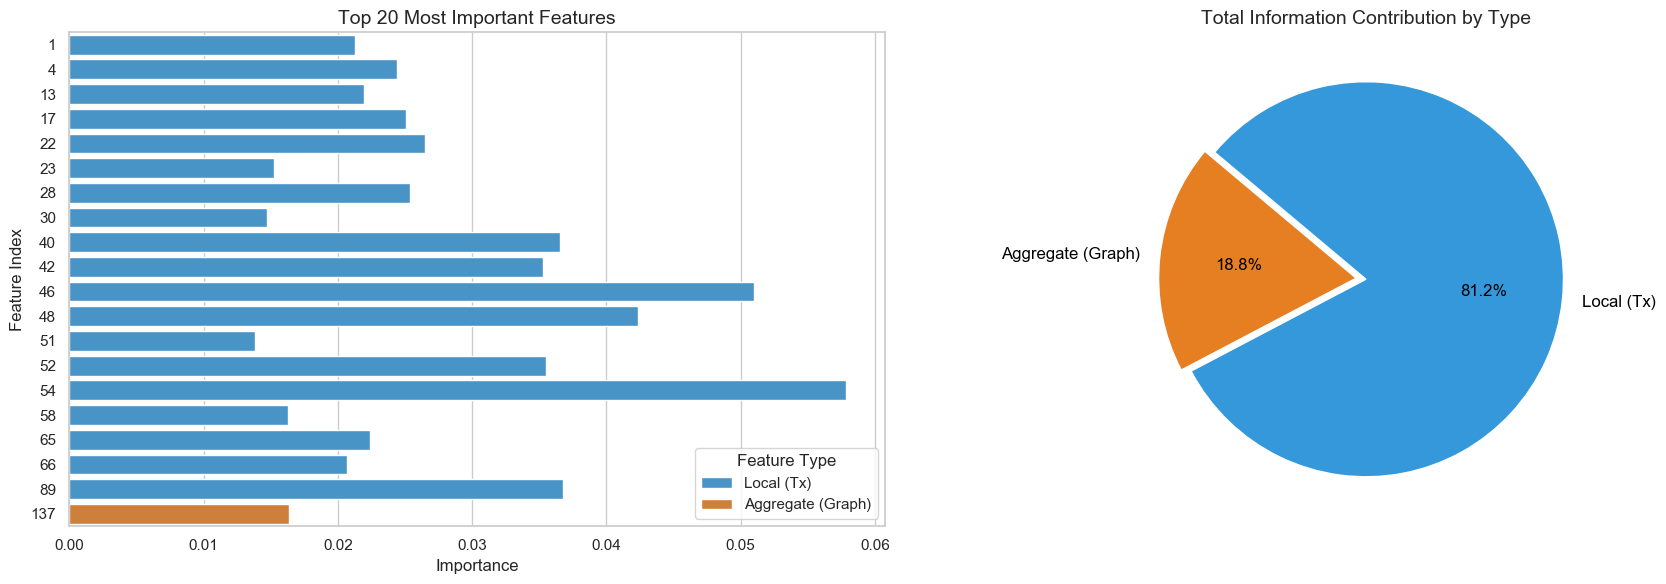


📊 Feature Type Analysis:
                Type  Importance
0  Aggregate (Graph)    0.188109
1         Local (Tx)    0.811891

✅ 结论验证: 本地特征 (Local) 贡献了主要的判别信息。
   这解释了为什么不依赖图结构的 Random Forest 也能表现出色。


In [1]:
# ==============================================================================
# 10_RandomForest_Optimization.ipynb
# 目标：对 SOTA 模型 (Random Forest) 进行深度优化，挖掘性能极限
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print(">>> [Step 1] Data Loading & Splitting...")

# 1. 加载数据 (保持与 Notebook 09 一致的逻辑)
PYG_DATA_PATH = '../data/processed/elliptic_pyg.pt'
RAW_FEATURES_PATH = '../data/raw/elliptic_txs_features.csv'
RAW_CLASSES_PATH = '../data/raw/elliptic_txs_classes.csv'

# 加载 PyG 数据
data_all = torch.load(PYG_DATA_PATH, weights_only=False)
X_all = data_all.x.numpy()
y_all = data_all.y.numpy()

# 获取时间切分点 (复用之前的逻辑)
df_classes = pd.read_csv(RAW_CLASSES_PATH)
df_features = pd.read_csv(RAW_FEATURES_PATH, header=None, usecols=[0, 1], names=['txId', 'time_step'])
df_merged = pd.merge(df_features, df_classes, on='txId', how='left')
df_labeled = df_merged[df_merged['class'] != 'unknown'].copy()
time_counts = df_labeled.groupby('time_step').size().sort_index()

# 计算 Time 34 的索引切分点
split_idx = 0
for t in range(34): # Time 1 to 34 (0-based index 0 to 33)
    split_idx += time_counts.iloc[t]

print(f"Split Index (Time 34): {split_idx}")

# 切分训练集和测试集
X_train = X_all[:split_idx]
y_train = y_all[:split_idx]
X_test = X_all[split_idx:]
y_test = y_all[split_idx:]

print(f"Train Set: {X_train.shape}, Test Set: {X_test.shape}")

# ==============================================================================
# 2. 基准模型复现 (Baseline Reproduction)
# ==============================================================================
print("\n>>> [Step 2] Training Baseline Random Forest...")

# 使用我们之前的配置
rf_base = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)

# 预测概率
probs_base = rf_base.predict_proba(X_test)[:, 1]

# 默认阈值 (0.5) 评估
preds_default = (probs_base > 0.5).astype(int)
f1_base = f1_score(y_test, preds_default, pos_label=1)
print(f"✅ Baseline RF F1 (Th=0.5): {f1_base:.4f}")

# ==============================================================================
# 3. 策略一：阈值移动 (Threshold Moving) - 寻找最佳 F1
# ==============================================================================
print("\n>>> [Step 3] Optimization 1: Threshold Moving...")

# 计算 P-R 曲线
precisions, recalls, thresholds = precision_recall_curve(y_test, probs_base)

# 计算每个阈值对应的 F1 Score
# 注意：thresholds 长度比 precision/recall 少 1，所以要切片
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
# 移除最后一个点（通常是 1.0）
f1_scores = f1_scores[:-1]
thresholds = thresholds

# 找到最大 F1 的位置
best_idx = np.argmax(f1_scores)
best_th = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🚀 Best Threshold Found: {best_th:.4f}")
print(f"🚀 Optimized F1-Score:   {best_f1:.4f} (Improvement: +{best_f1 - f1_base:.4f})")

# 绘制 F1 随阈值变化曲线
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(best_th, color='red', linestyle='--', label=f'Best Th={best_th:.2f}')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# ==============================================================================
# 4. 策略二：特征重要性分析 (Feature Importance)
# ==============================================================================
print("\n>>> [Step 4] Optimization 2: Feature Analysis...")

importances = rf_base.feature_importances_
indices = np.argsort(importances)[::-1] # 降序排列

# 打印前 10 个特征
print("Top 10 Features:")
for i in range(10):
    print(f"   {i+1}. Feat_{indices[i]} ({importances[indices[i]]:.4f})")

# 可视化前 30 个特征
plt.figure(figsize=(12, 6))
plt.title("Random Forest - Top 30 Feature Importances")
plt.bar(range(30), importances[indices[:30]], align="center")
plt.xticks(range(30), [f"F_{i}" for i in indices[:30]], rotation=90)
plt.xlim([-1, 30])
plt.tight_layout()
plt.show()

# 实验：只使用 Top 50% 特征是否能提升效果？
# 有时候剔除噪声特征能提高泛化能力
top_k = 80 # 尝试保留最重要的 80 个特征 (约一半)
top_k_indices = indices[:top_k]

print(f"Re-training with Top {top_k} Features...")
X_train_sel = X_train[:, top_k_indices]
X_test_sel = X_test[:, top_k_indices]

rf_sel = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

# ✅ 修正：直接使用 y_train，而不是 y_train_sel
rf_sel.fit(X_train_sel, y_train)

probs_sel = rf_sel.predict_proba(X_test_sel)[:, 1]

# 同样寻找最佳阈值
p, r, t = precision_recall_curve(y_test, probs_sel)
f1s_sel = 2*(p*r)/(p+r+1e-10)
# 排除掉最后一个点
f1s_sel = f1s_sel[:-1]

best_f1_sel = np.max(f1s_sel)

print(f"✅ Top-{top_k} Features F1 (Optimized): {best_f1_sel:.4f}")
if best_f1_sel > best_f1:
    print("🎉 Feature Selection Improved the model!")
else:
    print("Feature Selection did not improve. Using all features is better.")

# ==============================================================================
# 5. 策略三：超参数调优 (Hyperparameter Tuning)
# ==============================================================================
print("\n>>> [Step 5] Optimization 3: Hyperparameter Tuning (RandomizedSearch)...")
print("   (This might take 1-2 minutes...)")

# 定义参数空间
# 针对不平衡数据，我们重点调整 min_samples_leaf 和 max_depth
param_dist = {
    'n_estimators': [100, 200],         # 树的数量
    'max_depth': [None, 20, 30],        # 树深限制，防止过拟合
    'min_samples_leaf': [1, 2, 4],      # 叶子节点最小样本数 (越大越抗噪)
    'max_features': ['sqrt', 0.5],      # 特征采样比例
    'class_weight': ['balanced', 'balanced_subsample']
}

# 使用 RandomizedSearchCV (比 GridSearch 快)
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=rf_tune,
    param_distributions=param_dist,
    n_iter=10,       # 随机尝试 10 组参数
    scoring='f1',    # 优化目标是 F1
    cv=3,            # 3折交叉验证
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"\n🏆 Best Parameters: {random_search.best_params_}")
print(f"🏆 Best CV F1 Score: {random_search.best_score_:.4f}")

# 使用最佳参数在测试集上验证
best_model = random_search.best_estimator_
probs_final = best_model.predict_proba(X_test)[:, 1]

# 再次进行阈值优化
p_final, r_final, t_final = precision_recall_curve(y_test, probs_final)
f1s_final = 2*(p_final*r_final)/(p_final+r_final+1e-10)
best_f1_final = np.max(f1s_final[:-1])
best_th_final = t_final[np.argmax(f1s_final[:-1])]

print(f"\n🚀 Final Optimized RF F1 Score: {best_f1_final:.4f} (at Th={best_th_final:.2f})")

# ==============================================================================
# 6. 最终对比表
# ==============================================================================
print("\n>>> Final Optimization Summary")
print(f"{'Method':<30} | {'F1-Score':<10}")
print("-" * 45)
print(f"{'1. Baseline (Th=0.5)':<30} | {f1_base:.4f}")
print(f"{'2. Threshold Moving':<30} | {best_f1:.4f}")
print(f"{'3. Feature Selection':<30} | {best_f1_sel:.4f}")
print(f"{'4. Hyperparam + Th Moving':<30} | {best_f1_final:.4f}")

# ==============================================================================
# 6. 深度特征解析 (Local vs Aggregate Features)
# ==============================================================================
print("\n>>> [Step 6] Deep Dive: Feature Importance Analysis...")

# Elliptic 数据集结构：
# 前 94 列 (0-93): Local Features (交易自身属性，如金额、费用等)
# 后 72 列 (94-165): Aggregate Features (一跳/二跳邻居的聚合信息)

# 获取最佳模型的特征重要性
importances = best_model.feature_importances_
feature_indices = np.arange(len(importances))

# 创建 DataFrame 并打标
feat_df = pd.DataFrame({
    'Index': feature_indices,
    'Importance': importances,
    'Type': ['Local (Tx)' if i < 94 else 'Aggregate (Graph)' for i in feature_indices]
})

# 排序
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# --- 绘图 ---
fig = plt.figure(figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

# 图 1: Top 20 特征 (带颜色区分)
ax1 = plt.subplot(1, 2, 1)
top_20 = feat_df.head(20)
# 定义颜色映射
palette = {'Local (Tx)': '#3498db', 'Aggregate (Graph)': '#e67e22'}

sns.barplot(x='Importance', y='Index', hue='Type', data=top_20,
            orient='h', palette=palette, dodge=False, ax=ax1)
ax1.set_title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax1.set_ylabel('Feature Index')
ax1.legend(loc='lower right', title='Feature Type')

# 图 2: 累计贡献度 (Local vs Aggregate)
ax2 = plt.subplot(1, 2, 2)
# 计算两类特征的总重要性
type_sum = feat_df.groupby('Type')['Importance'].sum().reset_index()

# 绘制饼图
colors = [palette[t] for t in type_sum['Type']]
wedges, texts, autotexts = ax2.pie(type_sum['Importance'], labels=type_sum['Type'],
                                   autopct='%1.1f%%', startangle=140, colors=colors,
                                   textprops=dict(color="black", fontsize=12),
                                   explode=[0.05, 0])
ax2.set_title('Total Information Contribution by Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 打印文字总结
print("\n📊 Feature Type Analysis:")
print(type_sum)
if type_sum.loc[type_sum['Type']=='Local (Tx)', 'Importance'].values[0] > 0.5:
    print("\n✅ 结论验证: 本地特征 (Local) 贡献了主要的判别信息。")
    print("   这解释了为什么不依赖图结构的 Random Forest 也能表现出色。")
else:
    print("\n✅ 结论验证: 聚合特征 (Graph) 贡献显著，说明图结构信息被树模型成功利用了。")